# 0. Preliminaries

   ## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from IPython.display import HTML as html_print
import seaborn as sns    # for heatmaps

import logomaker         # if not present install with: pip install logomaker

## Parameters of the problem

In [2]:
# These are global variables to be used throughout the notebook
num_sequences = 50
sequence_length = 100
motif_length = 8
alpha = 1 # this alpha is used when estimating the motif

## Initialize the random number generator

In [3]:
random_seed = 2023
rng = np.random.default_rng(random_seed)

# 1. Generate the data

## Functions to generate and view a motif
We will represent the motif by a list length K of probability distributions over [0..3]

In [4]:
def sample_motif(motif_length=motif_length, alpha=0.1):
    """
    Create a motif from the dirichlet distribution
    """
    return rng.dirichlet([alpha]*4, motif_length) # fill using rng.dirichlet() 

def draw_motif(motif, title="", ax=None):
    """
    Draw a logo of the motif with logomaker
    """
    # Make dataframe for logomake
    df = pd.DataFrame(motif, columns=["A", "C", "G", "T"])
    df = logomaker.transform_matrix(df, from_type="probability", to_type="information")
    logo = logomaker.Logo(df, ax=ax)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        logo.ax.set_title(title)
        # logo.ax.set_xlabel("Position")
        logo.ax.set_ylabel("Total information")
        logo.ax.set_ylim(0, np.log2(4))
        logo.fig.show()
        

## Test out motif generation
Get the next cell to run yourself, by fixing the code in sample_motif() function above, then explore what happens as you vary alpha, e.g. to 0.5, 1, 5, perhaps 0.01. Try each value several times.

[[0.122 0.759 0.119 0.   ]
 [0.007 0.993 0.    0.   ]
 [0.275 0.723 0.001 0.001]
 [0.162 0.    0.    0.838]
 [0.428 0.    0.    0.572]
 [0.979 0.021 0.    0.   ]
 [0.336 0.    0.65  0.014]
 [0.13  0.    0.    0.87 ]]


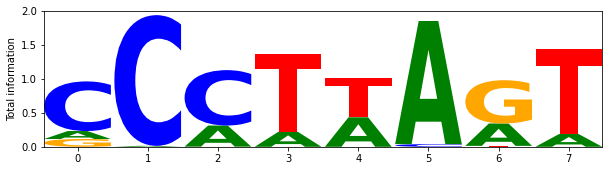

In [51]:
M = sample_motif(alpha = 0.1)
# print out the motif nicely
with np.printoptions(precision=3, suppress=True):
    print(M)
# draw the logo for the motif - we will use this function below to visualise motifs
draw_motif(M)

## Next we generate some example instances from a motif
The motifs we just made are probalistic models of sequences of length K.  Here we generate several examples of our current motif.  First you need to fill in the missing code in the function definition in the next cell, and run this to define the function. Then you can explore using it to sample instances of the motif. Try this with motifs made with different values of alpha (obtained by re-running the cell above with the desired value of alpha). Motifs made with smaller values of alpha should create more conserved sets of sample instances.

In [52]:
def sample_sequence_from_motif(motif):
    """
    Sample an instance of the motif from the distribution defined by the motif
    """
    # Initialize the sequence array
    motif_sequence = np.zeros(motif_length, dtype=int)

    # Draw each sequence element from motif
    for k in range(motif_length):
        motif_sequence[k] = rng.choice(4, size=1, p=motif[k, :]) # fill using rng.choice() 

    return motif_sequence

In [53]:
for i in range(10):
    seq = sample_sequence_from_motif(M)
    for s in seq:
        print ("ACGT"[s], end='')
    print()

CCCTTAGT
CCCTAAGT
GCCTTAGT
ACCATAGA
CCCAAAGT
CCCTTAGT
CCATAAGA
CCATTAAT
CCCTAAGT
CCCTTAGA


# 2. Estimate motif from sequences

Given instances, we wish to estimate motif.... (TODO)

In [65]:
def estimate_motif_from_sequences(sequences, alpha):
    """
    Estimate the motif by updating the prior Dirichlet distribution with observed sequences.
    """
    # Initialize
    sequences = np.array(sequences)
    
    # Initialize the motif array - each row corresponds to a position in the motif,
    # with 4 columns per row for the probabilities of the four possible nucleotides
    motif_estimate = np.zeros((motif_length, 4), dtype=float)   
    
    # Add dirichlet prior
    motif_estimate += alpha
    
    # Build the estimate
    for k in range(motif_length):
        for n in range(len(sequences)):
            # Which nucleotide is in the k-th position of the n-th sequence?
            j = sequences[n, k]

            # Update the respective estimate
            motif_estimate[k, j] += 1
                
        # After updating, divide the row by the sum to normalize to a sum of 1
        # This takes the expectation of the updated, posterior Dirichlet distribution
        total = 0
        for i in range(4):
            total += motif_estimate[k, i]
        for i in range(4):
            motif_estimate[k, i] /= total
        
    return motif_estimate
        
    

In [66]:
sequences_from_motif = []
for i in range(1000):
    sequences_from_motif.append(sample_sequence_from_motif(M))


In [67]:
estimate_motif_from_sequences(sequences_from_motif, 1)

array([[0.13047809, 0.74800797, 0.12051793, 0.00099602],
       [0.01195219, 0.98406375, 0.00298805, 0.00099602],
       [0.27589641, 0.72111554, 0.00199203, 0.00099602],
       [0.15438247, 0.00099602, 0.00099602, 0.8436255 ],
       [0.45219124, 0.00099602, 0.00099602, 0.54581673],
       [0.97410359, 0.02390438, 0.00099602, 0.00099602],
       [0.33067729, 0.00099602, 0.64442231, 0.02390438],
       [0.12649402, 0.00099602, 0.00099602, 0.87151394]])

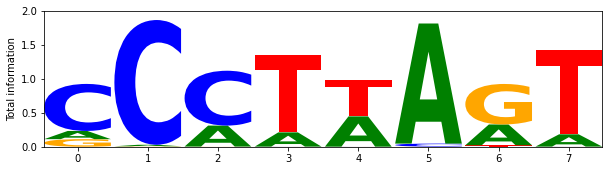

In [68]:
draw_motif(_)

# 3. Estimate position in sequence given motif

## First, generate a set of sequences that each incorporate one copy of the motif

In [8]:
def generate_sequences(motif):
    """
    Sample a set of sequences, with a single instance of the motif 
    embedded at a random position in each sequence
    """        
    # Initialize the sequences matrix with random bases
    # This matrix has a row per sequence, and the number of columns is the sequence length. The
    # row contains the sequence encoded into 0,1,2 and 3.
    sequences = rng.integers(4, size=(num_sequences, sequence_length))

    # Draw positions for motifs - each position can be from 0 to sequence_length - motif_length.
    # Draw one position per sequence.
    positions = rng.integers(sequence_length - motif_length + 1, size=num_sequences)

    # Per full sequence, draw from motif and insert
    for n in range(num_sequences):
        sequences[n, positions[n]:positions[n]+motif_length] = sample_sequence_from_motif(motif) # replace the subsequence of length motif_length at positions[n] with a motif instance
            
    return sequences, positions


def cstr(s, color='black'):
    return "<text style='color:{};font-family:monospace;font-size:1em'>{}</text>".format(color, s)

def draw_sequences(sequences, positions=None):
    """
    Show the sequences in nice text, optionally highlighting the motif positions in red
    """
    text = ""
    for n in range(len(sequences)):
        row = ""
        for s in sequences[n]:
            row += "ACGT"[s]
        row += "\n"
        
        # If no positions to show, everything is black
        if positions is None:                  
            row = cstr(row, color='black')
    
        # Otherwise, color in red
        else:
            pos = positions[n]
            row = \
                cstr(row[:pos], color="black") + \
                cstr(row[pos:pos+motif_length], color="red") + \
                cstr(row[pos+motif_length:], color="black")
        
        text += row
    
    display(html_print(text))


In [69]:
sequences, positions = generate_sequences(M)
draw_sequences(sequences[:20], positions)  # use without positions to show without highlighting

## What is the posterior distribution a position given a sequence and motif?

In [72]:
def posterior_position_given_sequence_and_motif(sequence, motif):
    
    # Initialize an array to hold the posterior distribution
    max_position = sequence_length - motif_length + 1
    posterior_distribution = np.zeros(max_position, dtype=float)
    
    # For each possible position...
    for i in range(max_position):
        prob = 1.0
        # Calculate the probability of seeing the sequence given the motif
        for k in range(motif_length):
            # Which nucleotide is at the k-th position of the sequence?
            j = sequence[i+k]
            
            # Multiply the probability of seeing this nucleotide according to the motif
            prob *= motif[k, j]
            
        # Save this probability
        posterior_distribution[i] = prob
        
    # Normalize by the sum, to have a proper distribution
    total = 0
    for i in range(max_position):
        total += posterior_distribution[i]
    for i in range(max_position):
        posterior_distribution[i] /= total
        
    return posterior_distribution

### Test

In [85]:
pp = posterior_position_given_sequence_and_motif(sequences[7], M)

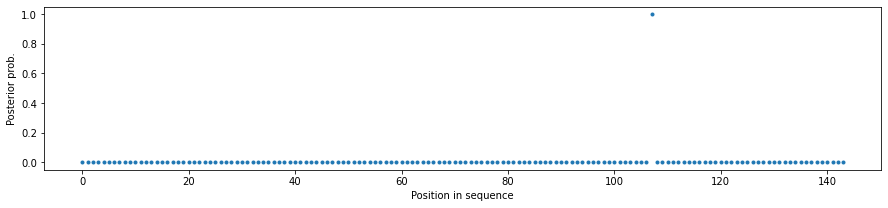

In [88]:
fig, ax = plt.subplots(figsize=(15, 3));
ax.plot(pp, '.');
ax.set_xlabel("Position in sequence");
ax.set_ylabel("Posterior prob.");

# 3. Monte-Carlo Markov Chain (MCMC)

As before we first define the necessary functions, with you having to fill in some missing fields to ensure that you read the code and understand what is being done.

## 3.1. Gibbs Sampling

In [94]:
def plot_results(iters, est_motif, lls, posteriors, motifs):
    print (f"LL with true motif {log_likelihood(sequences, M)}")
    print (f"LL with final estimated motif {log_likelihood(sequences, est_motif)}")
       
    # plot the true and final estimated motifs
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    draw_motif(M, ax=axs[0])
    axs[0].set_title("True motif")
    draw_motif(est_motif,ax=axs[1])
    axs[1].set_title("Final estimated motif")
    
    if lls is not None:
        # plot the log likelihoods
        plt.figure()
        plt.plot(lls)
        plt.xlabel("# of iteration")
        plt.ylabel("log likelihood")
    
    # plot heatmaps of the motif locations at given iterations
    if len(iters) > 0 and posteriors is not None:
        fig, axs = plt.subplots(1, len(iters), figsize=(20, 8))
        for ax, n_iter in zip(axs, iters):
            sns.heatmap(posteriors[n_iter][:,:], ax=ax, vmin=0, vmax=1);
            ax.set_title(f"Iteration # {n_iter}")
            ax.set_ylabel("Sequence #")
            ax.set_xlabel("Position")
    
    # and below them the motifs
    if len(iters) > 0 and motifs is not None:
        fig, axs = plt.subplots(1, len(iters), figsize=(20, 2))
        for ax, n_iter in zip(axs, iters):
            draw_motif(motifs[n_iter],ax=ax)

In [91]:
def log_likelihood_with_positions(sequences, positions, motif):

    # Initialize
    ll = 0.0
    max_position = sequence_length - motif_length + 1
    
    # Per sequence, add the log-likelihood
    for n in range(num_sequences):
        sequence = sequences[n]
        start_position = positions[n]
        
        prob = 1.0
        for k in range(motif_length):
            prob *= motif[k, sequence[start_position + k]] 
            
        ll += np.log(prob)
                        
    return ll

In [89]:
def gibbs_sample_positions(sequences, estimated_motif):

    max_position = sequence_length - motif_length + 1

    # Initialize an array to hold the new positions, per sequence
    positions = np.zeros(len(sequences), dtype=int)
    
    # Per sequence, draw a new position:
    for n in range(num_sequences):
        # Get the posterior distribution over positions, for this sequence
        sequence = sequences[n]
        positions_posterior = posterior_position_given_sequence_and_motif(sequence, estimated_motif)
        
        # Draw the new position from the posterior
        positions[n] = rng.choice(max_position, p=positions_posterior) # fill in the distribution used to select the position
        
    return positions


In [90]:
def calculate_posterior_dirichlet_parameters(alpha, sequences, positions, motif_length):

    max_position = sequence_length - motif_length + 1
    
    # Calculate the posterior dirichlet parameters
    posterior_parameters = np.ones((motif_length, 4), dtype=float) * alpha    
    for k in range(motif_length):
        for n in range(num_sequences):
            sequence_start_position = positions[n]
            a = sequences[n, sequence_start_position + k]
            posterior_parameters[k, a] += 1            
    
    return posterior_parameters
    

In [22]:
def gibbs_sample_motif(alpha, sequences, est_positions, motif_length):

    max_position = sequence_length - motif_length + 1
    
    # Calculate the dirichlet parameters
    dirichlet_parameters = calculate_posterior_dirichlet_parameters(alpha, sequences, est_positions,motif_length)
    
    # Draw new motif from this distribution
    est_motif = np.zeros((motif_length, 4), dtype=float)
    for k in range(motif_length):
        est_motif[k, :] = rng.dirichlet(dirichlet_parameters[k]) # fill in the parameter set to sample from
        
    return est_motif
    

In [92]:
def mcmc_gibbs_sampling(sequences, motif_length, alpha, n_iterations, print_every=None):

    # Initialize the motif estimate randomly
    estimated_motif = rng.random(size=(motif_length, 4))
    
    # Divide each row by its sum
    for k in range(motif_length):
        total = 0
        for i in range(4):
            total += estimated_motif[k, i]
        for i in range(4):
            estimated_motif[k, i] /= total
    
    # Initialize random positions
    max_position = sequence_length - motif_length + 1
    estimated_positions = rng.integers(max_position, size=num_sequences)
        
    # MCMC iterations
    lls = []
    motifs = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        motifs.append(estimated_motif)
        ll = log_likelihood_with_positions(sequences, estimated_positions, estimated_motif)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
            
        # Draw new positions
        estimated_positions = gibbs_sample_positions(sequences, estimated_motif)
        
        # Draw new motif
        estimated_motif = gibbs_sample_motif(alpha, sequences, estimated_positions, motif_length)
        
    return estimated_motif, lls, motifs
    

## Run it several times, both with shifts off (default) and shifts on

TODO: Edit this text.

How do these results compare with the EM solutions?

Look carefully at the log_likelihood values for the final solution. How are the final estimated motifs and their likelihoods different from those obtained by EM?

What happens when we allow shift operations using Metropolis-Hastings?

How does the number of iterations required compare with EM? What might be sensible numbers for the burn-in period and for taking random samples from the Markov chain? 

Maybe it would be interesting to try MCMC with a variety of motifs made with different values of alpha (remember to sample new sequences also when you make a new motif M).

Iteration 0: LL = -2537.0655884519474
Iteration 50: LL = -1106.4591759261118
Iteration 100: LL = -1132.545141891787
Iteration 150: LL = -1121.1087594002872
Iteration 200: LL = -1127.970805327926
Iteration 250: LL = -1132.6127136686962
Iteration 300: LL = -1138.99271328374
Iteration 350: LL = -1127.1293030471008
Iteration 400: LL = -1160.6519755936567
Iteration 450: LL = -1167.0792988465028
LL with true motif -41328.546001666116
LL with final estimated motif -41647.01552765199


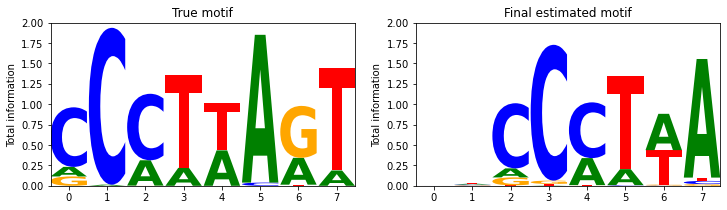

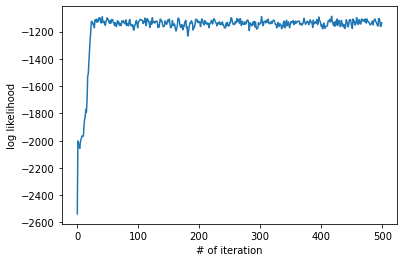

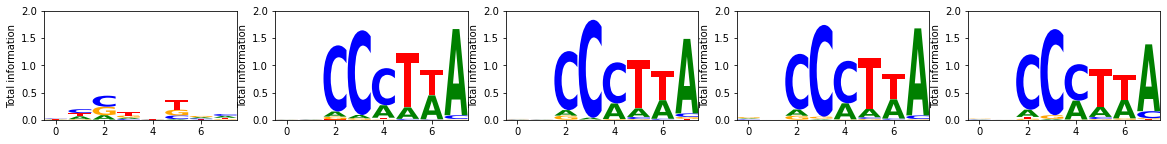

In [93]:
est_motif, lls, motifs = mcmc_gibbs_sampling(sequences, motif_length, alpha, 500, print_every=50)
plot_results([0,50,100,200,400], est_motif, lls, None, motifs)

In [26]:
# this is a useful cell of code repeated from above that can be run to change the motif and sequences

M = sample_motif(alpha = 0.2)       # try alpha = 0.2, 0.5, 1, perhaps even more
# if it hasn't converged correctly you could try generating more sequences by uncommenting/changing the next line
# num_sequences = 100
sequences, positions = generate_sequences(M)

## 3.2. Metropolis

In [96]:
def metropolis_step(sequences, estimated_positions, estimated_motif, current_ll, max_position):
    
    max_position = sequence_length - motif_length + 1

    # Make new state
    if rng.random() < 0.5:
        # abcdefgh -> habcdefg
        new_motif = np.roll(estimated_motif, 1, axis=0)
        new_positions = (estimated_positions - 1) % max_position
    else:
        # abcdefgh -> bcdefgha
        new_motif = np.roll(estimated_motif, -1, axis=0)
        new_positions = (estimated_positions + 1) % max_position
        
    # Calculate likelihood of new state
    new_ll = log_likelihood_with_positions(sequences, new_positions, new_motif)
    
    # Acceptance ratio
    acceptance_ratio = min(1.0, np.exp(new_ll - current_ll))
    
    # Accept if needed
    if rng.random() < acceptance_ratio:
        return new_motif, new_positions, True
    else:
        return estimated_motif, estimated_positions, False
        

In [97]:
def mcmc_metropolis_sampling(sequences, motif_length, alpha, n_iterations, print_every=None):

    # Initialize the motif estimate randomly
    estimated_motif = rng.random(size=(motif_length, 4))
    
    # Divide each row by its sum
    for k in range(motif_length):
        total = 0
        for i in range(4):
            total += estimated_motif[k, i]
        for i in range(4):
            estimated_motif[k, i] /= total
    
    # Initialize random positions
    max_position = sequence_length - motif_length + 1
    estimated_positions = rng.integers(max_position, size=num_sequences)
        
    # MCMC iterations
    lls = []
    motifs = []
    all_shifted = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        motifs.append(estimated_motif)
        ll = log_likelihood_with_positions(sequences, estimated_positions, estimated_motif)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
            
        # Draw new positions
        estimated_positions = gibbs_sample_positions(sequences, estimated_motif)
        
        # Draw new motif
        estimated_motif = gibbs_sample_motif(alpha, sequences, estimated_positions, motif_length)
        
        # Possible shift
        estimated_motif, estimated_positions, shifted = \
            metropolis_step(sequences, estimated_positions, estimated_motif, ll, max_position)
        
        all_shifted.append(shifted)
        
    return estimated_motif, lls, motifs
    

Iteration 0: LL = -2598.459229793707
Iteration 50: LL = -730.1447727410962
Iteration 100: LL = -710.2128800605371
Iteration 150: LL = -718.1890421061476
Iteration 200: LL = -718.1621117603024
Iteration 250: LL = -710.580065843588
Iteration 300: LL = -721.1818034157352
Iteration 350: LL = -720.1470493458111
Iteration 400: LL = -725.9351265202812
Iteration 450: LL = -715.0175646290628
LL with true motif -41328.546001666116
LL with final estimated motif -41344.10791540484


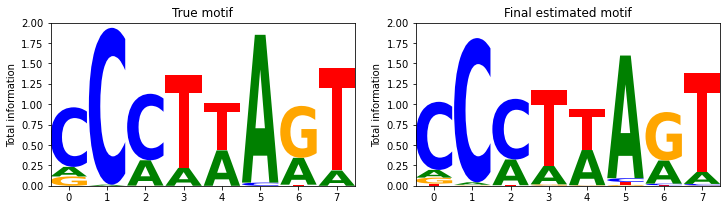

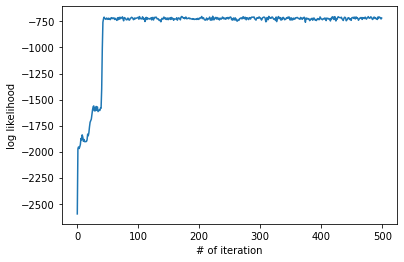

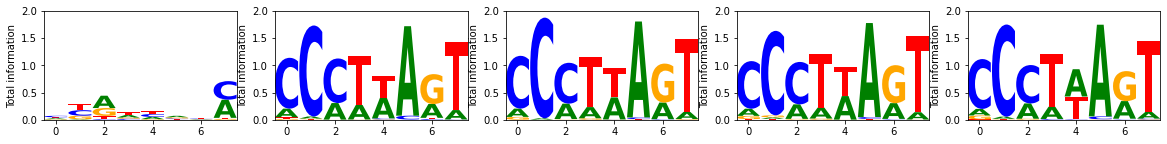

In [98]:
est_motif, lls, motifs = mcmc_metropolis_sampling(sequences, motif_length, alpha, 500, print_every=50)
plot_results([0,50,100,200,400], est_motif, lls, None, motifs)

# 4. Real data
Here we will explore a real data set of 200 promoter sequences identified in [Serizay et al. (2020)](https://genome.cshlp.org/content/30/12/1752.long) as being active in genes with tissue-specific expression in the intestine of the nematode *C. elegans*.

In [27]:
# First we upload the data set
# pip install biopython
from Bio import SeqIO

fasta_sequences = SeqIO.parse(open("elegans_intestine.WS235.fa"),'fasta')

sequences = []
for fasta in fasta_sequences:
    s = str(fasta.seq)
    table = s.maketrans('ACGT','0123')
    s = s.translate(table)
    s = np.array(list(s)).astype(int)
    sequences.append(s)

sequences = np.array(sequences)
num_sequences, sequence_length = sequences.shape
print("num_sequences", num_sequences, "sequence_length", sequence_length)

num_sequences 200 sequence_length 151


## Now we can run our EM program
Try running it several times.

It is likely that you will get different outcomes. This is because with real data there may be more than one pattern present, unlike in our simulations. Also unlike in our simulations, in real data the background model of a simple 0.25 probability per base is clearly over-simplified.

Iteration 0: LL = -41924.27568917827
Iteration 10: LL = -41593.97888697229
Iteration 20: LL = -41588.81119742523
Iteration 30: LL = -41579.78393491093
Iteration 40: LL = -41573.28655082448


Text(0, 0.5, 'log likelihood')

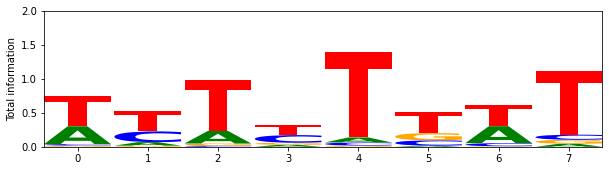

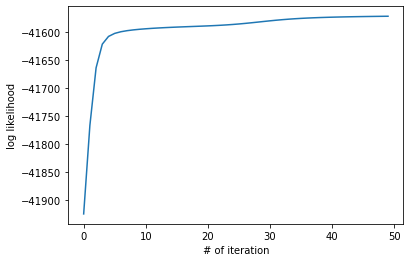

In [28]:
# now we can run our EM algorithm
# try running this several times
est_motif, lls, positions_posteriors, motifs = expectation_maximization(sequences, 50, print_every=10)
draw_motif(est_motif)
plt.figure()
plt.plot(lls)
plt.xlabel("# of iteration")
plt.ylabel("log likelihood")


## Parallel search for high scoring motifs
Because different random starts given different results, we will run 20 jobs in parallel, then sort the results by score.

You need to wait until you see "Done 20 out of 20" in order for all the jobs to finish, before sorting and printing in the next cell.  How many run at once depends on the computer you are working on.

How many fundamentally different patterns do you find?

In [29]:
# to find the top matches, run EM 20 times and sort the results by the log likelihood

import joblib

results = joblib.Parallel(n_jobs=-1,verbose=100)(   # this uses all available cores to parallelise
    joblib.delayed(expectation_maximization)(sequences, 31, print_every=10, parallel=True)
        for i in range(20)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:   12.0s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:   12.1s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   12.2s remaining:   49.0s
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:   12.3s remaining:   36.9s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:   12.4s remaining:   28.9s
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:   12.5s remaining:   23.2s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   12.6s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:   12.6s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   13.1s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   22.1s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapse

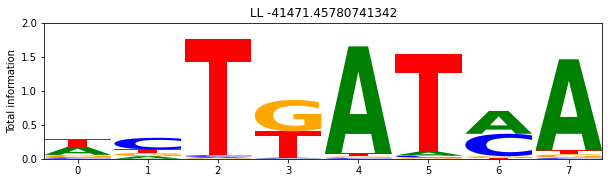

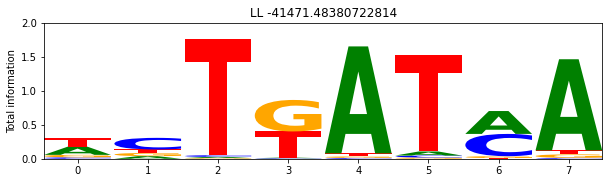

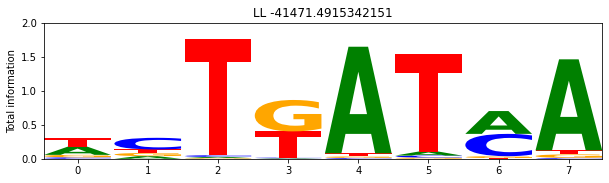

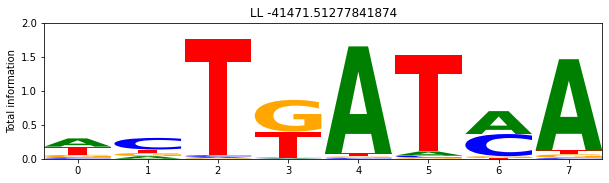

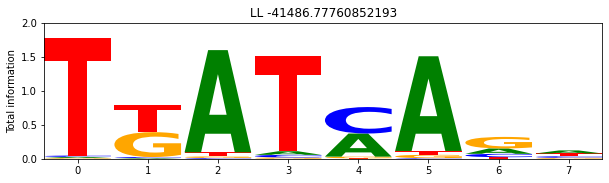

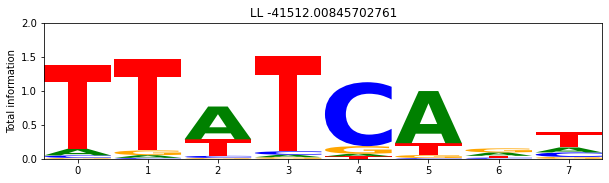

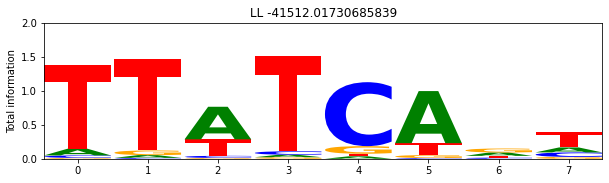

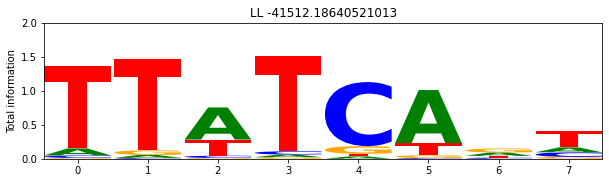

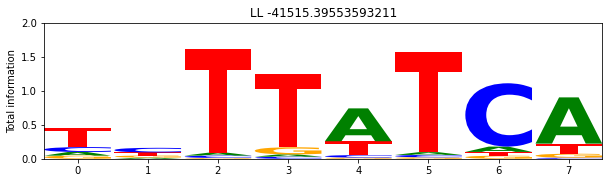

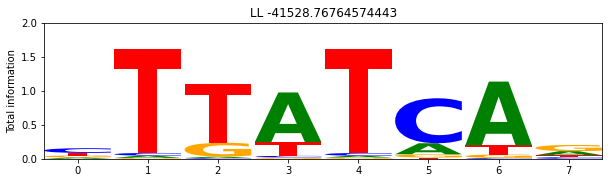

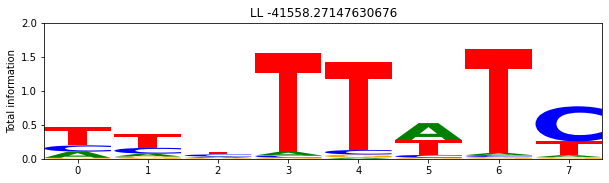

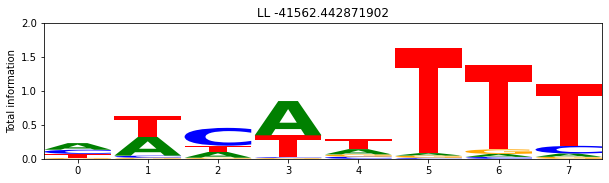

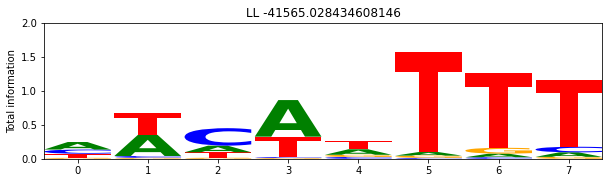

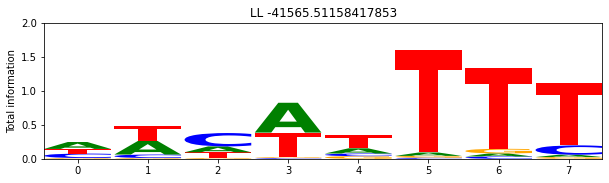

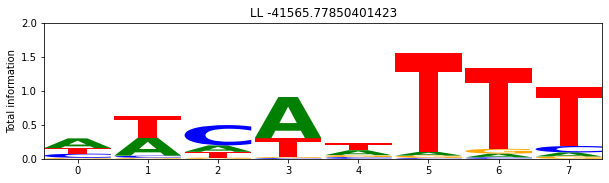

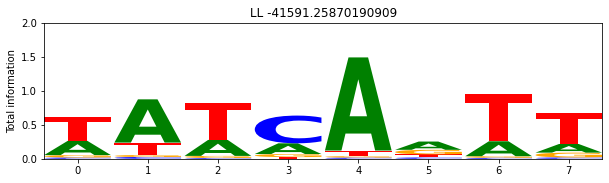

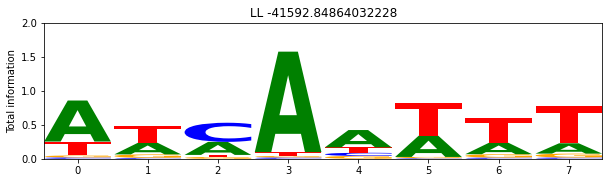

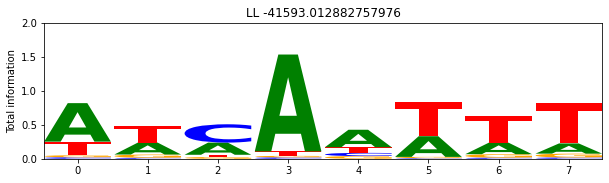

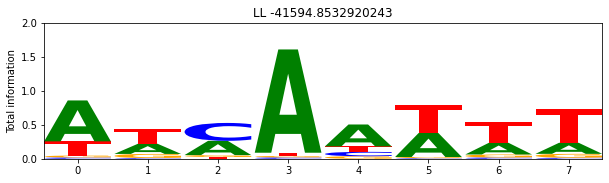

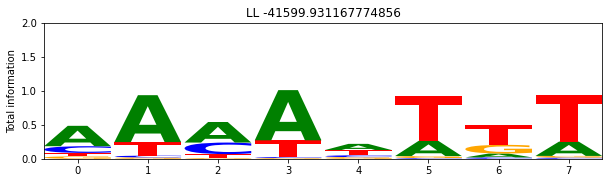

In [30]:
# store just the final log likelihoods and motifs in list LLmotif, then sort

LLmotif = []
for R in results:
    LLmotif.append([R[1][-1],R[0]])  # the final log likelihood and the motif
from operator import itemgetter
LLmotif.sort(key=itemgetter(0), reverse=True)
for x in LLmotif:
    draw_motif(x[1], title=f"LL {x[0]}")

## Compare to MEME

This is [a link to the output of a MEME run](https://meme-suite.org/meme//opal-jobs/appMEME_5.5.016744305844412056779887/meme.html) on the same sequences, using default parameters in the OOPS (One Occurrence Per Sequence) mode.

Are there similarities, or differences, between your high scoring motifs and the ones found by MEME? You should note that MEME is much more sophisticated, searching both strands, with a background model that it learns from the data.

## Search in the JASPAR database using Tomtom

The [JASPAR](https://jaspar.genereg.net/) database contains a curated set of previously established binding motif patterns for hundreds of transcription factors and species, including *C.elegans*.

You can search it to find known patterns similar to motifs you have found using another program in the MEME suite, [TomTom](https://meme-suite.org/meme/tools/tomtom). 

To load your motifs found in from the worm intestine practical into TomTom, you need to first write them out as a file in MEME minimal format. Below we define code to do that, then give instructions to upload this file to the TomTom web site.
    
What does your lead pattern correspond to?  Remember that the sequence you obtain may be the reverse complement of what MEME finds (it searches both strands).

In [31]:
def write_MEME_file(motifs, file_name="MCB.meme", motif_name="MCB"):
    with open(file_name,'w') as f:
        # write header
        f.write("MEME version 5.5.0\n\n")
        f.write("ALPHABET= ACGT\n\n")
        f.write("strands: + -\n\n")
        # write motifs
        count = 0
        for m in motifs:
            count = count + 1
            f.write(f"MOTIF {motif_name}-{count}\n\n")
            f.write(f"letter-probability matrix: alength= 4 w= {motif_length}\n")
            np.savetxt(f, m, delimiter=' ', fmt='%.4f')
            f.write("\n")
        f.close()
    print(len(motifs), "motifs written")

In [32]:
write_MEME_file([LLmotif[0][1], LLmotif[8][1]]) # list here the motifs you want, e.g. numbers 0 and 8 in the sorted list

2 motifs written
Iteration 0: LL = -41892.42127070626
Iteration 10: LL = -41616.114588615164
Iteration 20: LL = -41535.57139865696
Iteration 30: LL = -41512.18640521013
Iteration 0: LL = -41895.70675108328
Iteration 10: LL = -41612.10104206734
Iteration 20: LL = -41485.95675611829
Iteration 30: LL = -41471.4915342151
Iteration 0: LL = -41973.76435764778
Iteration 10: LL = -41478.089102329606
Iteration 20: LL = -41471.47392719047
Iteration 30: LL = -41471.45780741342
Iteration 0: LL = -41810.037157663624
Iteration 10: LL = -41623.065236635506
Iteration 20: LL = -41544.8274170001
Iteration 30: LL = -41528.76764574443
Iteration 0: LL = -41959.99504353876
Iteration 10: LL = -41633.02691791722
Iteration 20: LL = -41562.62421736736
Iteration 30: LL = -41486.77760852193
Iteration 0: LL = -41874.72512058346
Iteration 10: LL = -41620.3995922915
Iteration 20: LL = -41602.19103459497
Iteration 30: LL = -41594.8532920243
Iteration 0: LL = -41933.11145053914
Iteration 10: LL = -41612.29789000926
It

## Search in TomTom
* go to the [TomTom submission link](https://meme-suite.org/meme/tools/tomtom)
* upload the file you have just written (called MCB.meme, unless you renamed it)
* select the "JASPAR (NON-REDUNDANT) DNA" target motif database
* select the "JASPAR CORE (2022) nematodes", unless you want to search all species, in which case leave it as "JASPAR CORE"
* tick the "Search with one motif (faster queue)" box
* press "Start search"

What do you find?

## Another promoter region file

If you enjoyed that, and have time left, there is another file elegans_muscle.WS235.fa you can try, containing 200 promoter sequences from muscle genes, from the same paper.